In [3]:
import pandas as pd
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
from torchvision import models
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
from typing_extensions import dataclass_transform
import random
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

torch.manual_seed(42)
np.random.seed(42)

In [4]:
class SkinData:
  def __init__(self, root, transform = True, train = True):
      if train:
        data_folder = 'balanced_dataset/'

      else:
        data_folder = 'Validation Image/'

      data_dirs = os.listdir(os.path.join(root,data_folder))
      self.data_files = []
      self.labels = []
      label = 0
      for dir in data_dirs:
        path_name = os.path.join(root,data_folder,dir)
        data_samples = [os.path.join(path_name, fname) for fname in os.listdir(path_name)]
        label_samples = label * np.ones(len(data_samples))
        print(dir)
        print(len(label_samples))
        self.data_files.extend(data_samples)
        self.labels.extend(label_samples)
        self.transform = transform

        label += 1

  def __len__(self):
    return len(self.data_files)

  def __getitem__(self, index):
    new_width = 256
    new_height = 256
    data_file = self.data_files[index]
    image = np.array(cv2.imread(data_file))
    label = np.array(self.labels[index])

    data_sample = cv2.resize(image, (new_width, new_height))
    resize_data = np.array(data_sample)


    if self.transform:
      data_sample = torch.from_numpy(data_sample)
      lable = torch.from_numpy(label)

    data_point = {'data_sample': data_sample, 'lable':lable}

    return data_point

In [5]:
root = r'C:\Users\vindu\Documents\FYP\Skin Cancer'
dataset = SkinData(root, transform=True, train= True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_loder = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loder = DataLoader(test_dataset, batch_size=8, shuffle=False)

test_dataset = SkinData(root, transform=True, train = False)

dataloader_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=8, shuffle=False)
dataloader_val = DataLoader(val_dataset, batch_size=8, shuffle=False)

akiec
981
bcc
1028
bkl
1002
df
1035
mel
1002
nv
1002
vasc
994
akiec
16
bcc
26
bkl
55
df
6
mel
56
nv
335
vasc
7


In [6]:
len(train_dataset)

5635

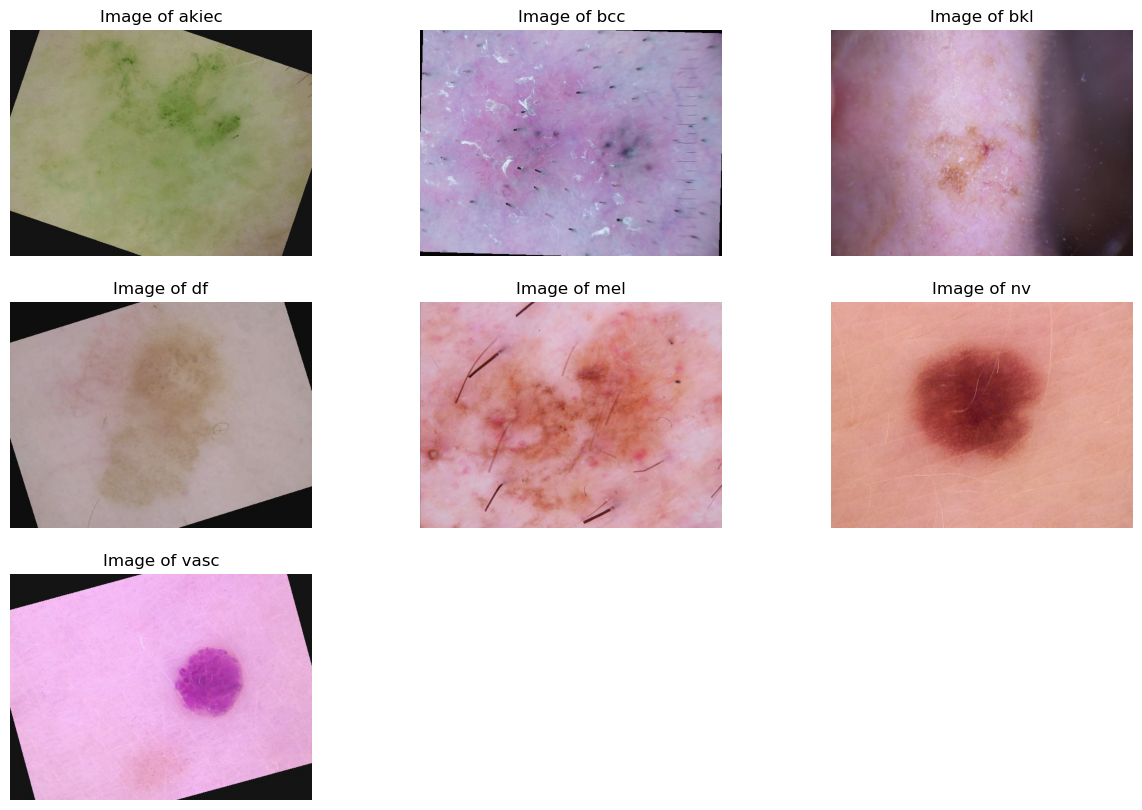

In [7]:
# Data Visualization
# Define the directory path for the training images
train_images_dir = r"C:\Users\vindu\Documents\FYP\Skin Cancer\Balanced_dataset"

top_n = 20  # Variable for top-n random images to select from.
image_sample = []  # List containing array of images.
image_sample_category = []  # List containing image type

# Make sure train_images_dir is correctly defined before this loop
for sub_dir in os.scandir(train_images_dir):
    images_paths = [image.path for image in os.scandir(sub_dir)]
    current_dir_img_paths = []  # List of top n images from current sub-dir.

    # Ensure we handle cases where there are fewer than top_n images
    num_images = min(len(images_paths), top_n)

    # Appending up to top_n images from the current sub-dir
    for image_path in images_paths[:num_images]:
        current_dir_img_paths.append(image_path)

    # Select a random image from the current directory
    if current_dir_img_paths:
        selected_image = random.choice(current_dir_img_paths)  # Selecting random image from the list
        image = cv2.imread(selected_image)  # Reading the image

        if image is not None:
            image = image[:, :, ::-1]  # Converting BGR to RGB
            image_sample_category.append(sub_dir.name)  # Append image category (cancer type)
            image_sample.append(image)  # Append the image array to the list
        else:
            print(f"Warning: Could not read image {selected_image}")
    else:
        print(f"No images found in directory {sub_dir.name}")

# Plotting the selected random images
plt.figure(figsize=(15, 10))
for num in range(len(image_sample)):
    plt.subplot(3, 3, num + 1)
    plt.axis(False)
    plt.title(f"Image of {image_sample_category[num]}")
    plt.imshow(image_sample[num])

plt.show()

tensor(0., dtype=torch.float64)


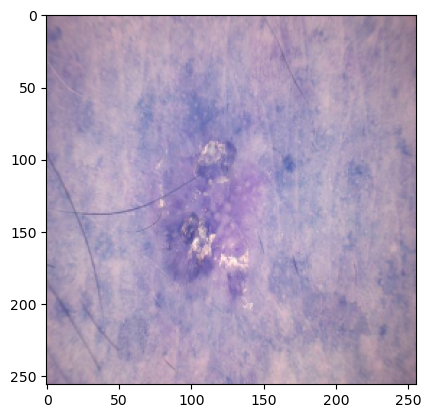

In [8]:
plt.imshow(train_dataset[1000]['data_sample'])
print(train_dataset[1000]['lable'])

In [9]:
train_dataset[1000]['data_sample'].shape

torch.Size([256, 256, 3])

In [10]:
# class CNNNet(nn.Module):
#   def __init__(self):
#     super (CNNNet, self).__init__()
#     self.main = nn.Sequential(
#         nn.Conv2d (in_channels=3, out_channels=8, kernel_size=(5,5), stride = (2,2), padding=2, bias = True, padding_mode='zeros'),
#         nn.ReLU(True),
#         nn.MaxPool2d (kernel_size=(2,2), stride=(2,2)), # 64 x 64 x 4
#         nn.Conv2d (in_channels=8, out_channels=16, kernel_size=(5,5), stride = (2,2), padding=2, bias = True, padding_mode='zeros'),
#         nn.ReLU(True),
#         nn.MaxPool2d (kernel_size=(2,2), stride=(2,2)), # 16 x 16 x 8
#         nn.Conv2d (in_channels=16, out_channels=32, kernel_size=(5,5), stride = (1,1), padding=2, bias = True, padding_mode='zeros'),
#         nn.ReLU(True),
#         nn.MaxPool2d (kernel_size=(2,2), stride=(2,2)), # 8 x 8 x 16
#         nn.Conv2d (in_channels=32, out_channels=64, kernel_size=(5,5), stride = (2,2), padding=2, bias = True, padding_mode='zeros'),
#         nn.ReLU(True),
#         nn.MaxPool2d (kernel_size=(2,2), stride=(2,2)), # 4 x 4 x 64
#         nn.Flatten(),
#         nn.Linear(256, 128, bias=True),
#         nn.ReLU(True),
#         nn.Linear(128, 64, bias=True),
#         nn.ReLU(True),
#         nn.Linear(64, 32, bias=True),
#         nn.ReLU(True),
#         nn.Linear(32, 7, bias=True),
#         nn.LogSoftmax(dim=1)
#         )
#   def forward(self, x):
#     out = self.main(x)
#     return out

In [11]:
# Train Accuracy: 73.26%, Validation Accuracy: 64.56%
import torch
import torch.nn as nn

class ImprovedCNNNet(nn.Module):
    def __init__(self):
        super(ImprovedCNNNet, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 256 x 256 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 128 x 128 x 32
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 128 x 128 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 64 x 64 x 64

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 64 x 64 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 32 x 32 x 128

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 32 x 32 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 16 x 16 x 256

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 16 x 16 x 512
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 8 x 8 x 512
            
            nn.Flatten(),  # Flatten the 8x8x512 to a vector
            nn.Linear(8 * 8 * 512, 1024, bias=True),
            nn.ReLU(True),
            nn.Dropout(0.5),  # Dropout to reduce overfitting
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 128, bias=True),
            nn.ReLU(True),
            nn.Linear(128, 7, bias=True),  # Output layer for 7 classes
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        out = self.main(x)
        return out

In [12]:
# import torch
# import torch.nn as nn

# class ImprovedCNN(nn.Module):
#     def __init__(self):
#         super(ImprovedCNN, self).__init__()
#         self.conv_layers = nn.Sequential(
#             # First convolutional block
#             nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=1),  # Output: 256x256x16
#             nn.InstanceNorm2d(16),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # Output: 128x128x16
            
#             # Second convolutional block
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=1),  # Output: 128x128x32
#             nn.InstanceNorm2d(32),  
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # Output: 64x64x32
            
#             # Third convolutional block
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=1),  # Output: 64x64x64
#             nn.InstanceNorm2d(64),  
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # Output: 32x32x64

#             # Fourth convolutional block
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1),  # Output: 32x32x128
#             nn.InstanceNorm2d(128), 
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # Output: 16x16x128

#             # Fifth convolutional block
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1),  # Output: 16x16x256
#             nn.InstanceNorm2d(256), 
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # Output: 8x8x256
#         )
        
#         self.fc_layers = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(256 * 8 * 8, 512),  
#             nn.InstanceNorm1d(512), 
#             nn.ReLU(True),
#             nn.Dropout(p=0.5),  
            
#             nn.Linear(512, 256), 
#             nn.InstanceNorm1d(256), 
#             nn.ReLU(True),
#             nn.Dropout(p=0.5),
            
#             nn.Linear(256, 128),  
#             nn.InstanceNorm1d(128),  
#             nn.ReLU(True),
#             nn.Dropout(p=0.5),
            
#             nn.Linear(128, 7),  
#             nn.LogSoftmax(dim=1)  
#         )
        
#     def forward(self, x):
#         x = self.conv_layers(x)
#         x = self.fc_layers(x)
#         return x

# # Example instantiation:
# # model = ImprovedCNN()
# 55%

In [13]:
# import torch
# import torch.nn as nn

# class ImprovedCNNNet(nn.Module):
#     def __init__(self):
#         super(ImprovedCNNNet, self).__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 256 x 256 x 32
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 128 x 128 x 32
            
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 128 x 128 x 64
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 64 x 64 x 64

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 64 x 64 x 128
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 32 x 32 x 128

#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 32 x 32 x 256
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 16 x 16 x 256

#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 16 x 16 x 512
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 8 x 8 x 512
            
#             nn.Flatten(),  # Flatten the 8x8x512 to a vector
#             nn.Linear(8 * 8 * 512, 1024, bias=True),
#             nn.LeakyReLU(True),
#             nn.Dropout(0.6),  # Increased Dropout to reduce overfitting
#             nn.Linear(1024, 512, bias=True),
#             nn.LeakyReLU(True),
#             nn.Dropout(0.6),
#             nn.Linear(512, 128, bias=True),
#             nn.LeakyReLU(True),
#             nn.Linear(128, 7, bias=True),  # Output layer for 7 classes
#             nn.LogSoftmax(dim=1)
#         )
    
#     def forward(self, x):
#         out = self.main(x)
#         return out

# model = ImprovedCNNNet()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
net = ImprovedCNNNet().to(device)

In [16]:
print(torch.cuda.get_device_name(0))  # To check your GPU device name
print(torch.cuda.is_available())  # To confirm GPU is available

NVIDIA GeForce RTX 3050 Laptop GPU
True


In [17]:
import torch.optim as optim
# Print the network architecture
print(net)
# Optimizer: Adamax
optimizer = optim.Adamax(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# Loss function
criterion = nn.CrossEntropyLoss()

ImprovedCNNNet(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(2

In [18]:
len(dataloader_train)

353

In [ ]:
# Lists to store average losses and accuracies per epoch
avg_train_loss_list = []
avg_val_loss_list = []
train_acc_list = []
val_acc_list = []

# Define the directory to save/load models
save_dir = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\Adamax'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to load the latest checkpoint
def load_checkpoint(model, optimizer, scheduler, filename='latest_checkpoint.pth'):
    if os.path.exists(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resuming from epoch {start_epoch}")
    else:
        print(f"No checkpoint found at '{filename}', starting from scratch")
        start_epoch = 0  # Start from scratch if no checkpoint
    return start_epoch

# Load checkpoint if exists
checkpoint_path = os.path.join(save_dir, 'latest_checkpoint.pth')
start_epoch = load_checkpoint(net, optimizer, scheduler, filename=checkpoint_path)

# Training Loop
for epoch in range(start_epoch,start_epoch+50):  # Now starts from the saved epoch
    accuracy = 0
    val_accuracy = 0
    running_loss = 0.0
    val_running_loss = 0.0
    num_batches_train = len(dataloader_train)
    num_batches_val = len(dataloader_val)

    # Training loop
    for i, data in enumerate(dataloader_train, 0):
        input = data['data_sample'].float().to(device)
        input = input.permute(0, 3, 1, 2)
        labels = data['lable'].to(device)
        encoded_labels = F.one_hot(labels.long(), num_classes=7)

        prediction = net(input)
        loss = criterion(prediction, encoded_labels.float())
        running_loss += loss.item()

        predicted_class = torch.argmax(prediction, dim=1)
        accuracy += sum(predicted_class == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print('epoch:', epoch, 'loss:', loss.item())

    avg_train_loss = running_loss / num_batches_train
    avg_train_loss_list.append(avg_train_loss)

    # Validation loop
    for i, data in enumerate(dataloader_val, 0):
        input = data['data_sample'].float().to(device)
        input = input.permute(0, 3, 1, 2)
        labels = data['lable'].to(device)
        encoded_labels = F.one_hot(labels.long(), num_classes=7)

        prediction = net(input)
        val_loss = criterion(prediction, encoded_labels.float())
        val_running_loss += val_loss.item()

        predicted_class = torch.argmax(prediction, dim=1)
        val_accuracy += sum(predicted_class == labels)

    avg_val_loss = val_running_loss / num_batches_val
    avg_val_loss_list.append(avg_val_loss)

    print(f'Epoch {epoch}: Train Accuracy: {accuracy/train_dataset.__len__()*100:.2f}%, '
          f'Validation Accuracy: {val_accuracy/val_dataset.__len__()*100:.2f}%')

    accuracy = accuracy.cpu().numpy()
    train_acc_list.append(accuracy / train_dataset.__len__() * 100)
    val_accuracy = val_accuracy.cpu().numpy()
    val_acc_list.append(val_accuracy / val_dataset.__len__() * 100)

    scheduler.step()

    # Save model checkpoint after each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss.item(),
    }, os.path.join(save_dir, 'latest_checkpoint.pth'))

    print(f'Model saved after epoch {epoch}')
    print(f'Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')

    # After each epoch, save metrics to a CSV file
    metrics_df = pd.DataFrame({
        'Epoch': [epoch],
        'Train Accuracy': [train_acc_list[-1]],
        'Validation Accuracy': [val_acc_list[-1]],
        'Average Train Loss': [avg_train_loss],
        'Average Validation Loss': [avg_val_loss]
    })

    metrics_df.to_csv(os.path.join(save_dir, 'training_metrics.csv'), mode='a', index=False, header=not os.path.exists(os.path.join(save_dir, 'training_metrics.csv')))
    print("Epoch metrics saved to training_metrics.csv")

No checkpoint found at 'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\Adamax\latest_checkpoint.pth', starting from scratch
epoch: 0 loss: 1.952263355255127
epoch: 0 loss: 1.7592734098434448
epoch: 0 loss: 1.674955129623413
epoch: 0 loss: 1.4997608661651611
epoch: 0 loss: 1.7135827541351318
epoch: 0 loss: 1.4495458602905273
epoch: 0 loss: 1.5870106220245361
epoch: 0 loss: 1.232424259185791
Epoch 0: Train Accuracy: 36.49%, Validation Accuracy: 38.47%
Model saved after epoch 0
Average Train Loss: 1.5587, Average Validation Loss: 1.4749
Epoch metrics saved to training_metrics.csv
epoch: 1 loss: 1.2605994939804077
epoch: 1 loss: 1.2061505317687988
epoch: 1 loss: 1.4051076173782349
epoch: 1 loss: 1.3385945558547974
epoch: 1 loss: 1.0683298110961914
epoch: 1 loss: 1.2705260515213013
epoch: 1 loss: 1.177396535873413
epoch: 1 loss: 0.9172725677490234
Epoch 1: Train Accuracy: 45.57%, Validation Accuracy: 48.90%
Model saved after epoch 1
Average Train Loss: 1.3414, Ave

In [ ]:
# Evaluation on Test Dataset
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in dataloader:
            inputs = data['data_sample'].float().to(device)
            inputs = inputs.permute(0, 3, 1, 2)  # Adjust dimensions for the model
            labels = data['lable'].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return all_labels, all_predictions

# Get predictions and labels for the test dataset
test_labels, test_predictions = evaluate_model(net, dataloader_test, device)

# Calculate metrics
conf_matrix = confusion_matrix(test_labels, test_predictions)
accuracy = accuracy_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions, average='weighted')
precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')

# Print metrics
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Normalize confusion matrix to percentages
conf_matrix_percentage = conf_matrix.astype(np.float32)
conf_matrix_percentage /= conf_matrix_percentage.sum(axis=1, keepdims=True)  # Normalize each row
conf_matrix_percentage *= 100  # Convert to percentage

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()

# Inside the training loop, after the validation loop
val_labels, val_predictions = evaluate_model(net, dataloader_val, device)

# Calculate metrics for validation
val_accuracy = accuracy_score(val_labels, val_predictions)
val_f1 = f1_score(val_labels, val_predictions, average='weighted')
val_precision = precision_score(val_labels, val_predictions, average='weighted')
val_recall = recall_score(val_labels, val_predictions, average='weighted')

# Print validation metrics
print(f'Train Accuracy: {(accuracy / len(train_dataset)) * 100:.2f}%, '
      f'Validation Accuracy: {(val_accuracy / len(val_dataset)) * 100:.2f}%')

# # Add these lines to the metrics DataFrame
# metrics_df['Validation Accuracy'] = val_accuracy
# metrics_df['Validation F1 Score'] = val_f1
# metrics_df['Validation Precision'] = val_precision
# metrics_df['Validation Recall'] = val_recall

Confusion Matrix:
[[  0   0   0  15   0   0   1]
 [  0   0   0  26   0   0   0]
 [  0   0   0  54   0   0   1]
 [  0   0   0   6   0   0   0]
 [  0   0   0  50   0   0   6]
 [  0   0   0 308   0   0  27]
 [  0   0   0   6   0   0   1]]
Accuracy: 0.0140
F1 Score: 0.0010
Precision: 0.0005
Recall: 0.0140


c:\Users\vindu\anaconda\envs\my\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>

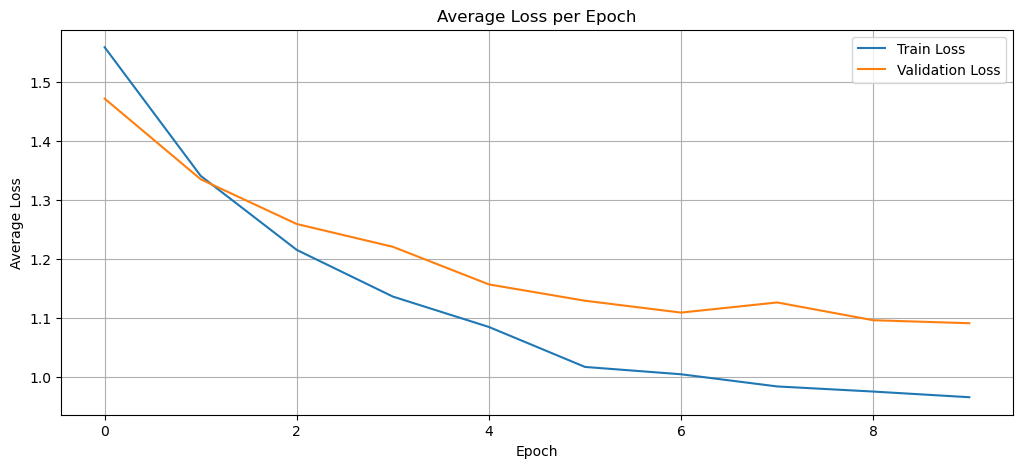

In [ ]:
# Path to the CSV file
csv_file_path = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\Adamax\training_metrics.csv'

# Load the metrics from the CSV file
metrics_df = pd.read_csv(csv_file_path)

# Plot Average Losses
plt.figure(figsize=(27, 5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(metrics_df['Epoch'], metrics_df['Average Train Loss'], label='Train Loss')
plt.plot(metrics_df['Epoch'], metrics_df['Average Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss per Epoch')
plt.legend()
plt.grid(True)

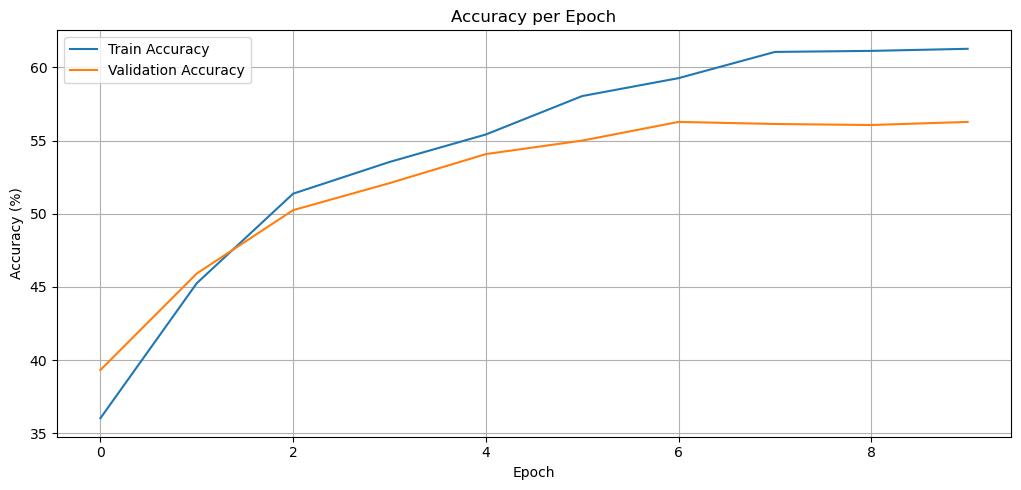

In [ ]:
# Plot Accuracies
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(metrics_df['Epoch'], metrics_df['Train Accuracy'], label='Train Accuracy')
plt.plot(metrics_df['Epoch'], metrics_df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()